# Maximin LinUCB

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit, hls_rank_combined
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls, make_hls_rank
from lrcb.representations.finite_representations import is_cmb, is_hls, spans, hls_lambda, derank_cmb, LinearRepresentation
from lrcb.representations.finite_representations import reduce_dim, fuse_columns
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
from lrcb.algos.maximin_oful import maximin_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu
from jupyterthemes import jtplot
#jtplot.style()
plt.rcParams['figure.figsize'] = [12, 9]

## Common settings

In [2]:
nc = 20
na = 4
dim = 5
noise = 0.1
seeds = range(5)

Generate original HLS representation

In [3]:
#r0 = make_random_rep(nc, na, dim, normalize=True)
r0 = LinearRepresentation(np.load('../logs/basic_features.npy'), np.load('../logs/basic_param.npy'))
assert is_hls(r0)

OFUL settings

In [4]:
iterations = 10000
reg = 1
delta = 0.01
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

## Basic Problem

5 equivalent representations of dimension 5, of increasing hls rank, only one is HLS (the last)

In [5]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

for r in reps:
    print('%d/%d' % (hls_rank(r), rank(r)))

1/5
2/5
3/5
4/5
5/5


OFUL with different representations

In [6]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'basic_oful(%d)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

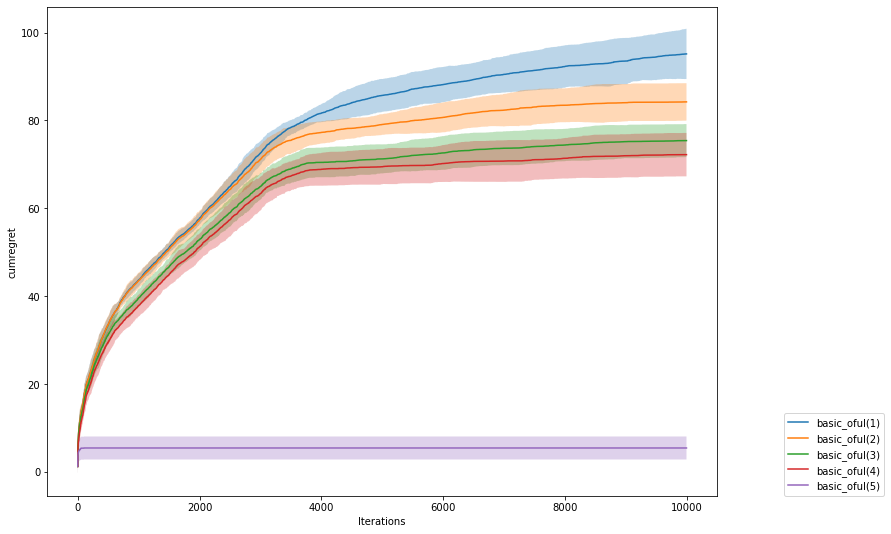

In [7]:
nu.compare('../logs', ['basic_oful(%d)' % hls_rank(r) for r in reps], 'cumregret', seeds)

In [6]:
oracle = 'basic_oful(5)'
dummy = 'basic_oful(4)'

## Comparison of different strategies

For model-selection algorithm, start from random active representation and divide confidence by n. reps.

In [7]:
problem.reset()
delta2 = delta / len(reps)

**lambdamin(u)**: select representation with largest minimum eigenvalue of optimal features according to uniform distribution and estimated optimal actions

In [10]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='basic_lambdamin(u)')

**lambdamin**: same with empirical context distribution

In [11]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='basic_lambdamin')

**design**: select representation with largest minimum eigenvalue of design matrix

In [12]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='basic_design')

**minbonus**: select representation with minimum optimistic bonus

In [13]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='basic_minbonus')

**maximin**: use the tightest UCB for each arm

In [14]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='basic_maximin')

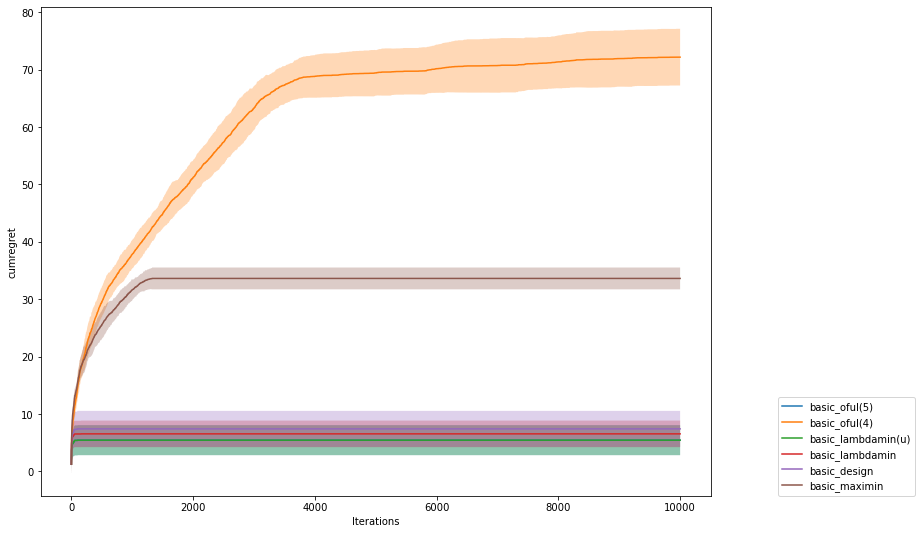

In [10]:
nu.compare('../logs', [oracle, dummy, 'basic_lambdamin(u)', 'basic_lambdamin', 'basic_design', 'basic_maximin'], 
           'cumregret', seeds)

## Effect of the Number of Representations

In [16]:
values = [2, 4, 8, 16, 32]
for n_reps in values:
    reps = [r0]
    for _ in range(n_reps - 1):
        reps.append(derank_hls(r0, 1, transform=True, normalize=True))
    problem = FiniteMultiBandit(nc, na, reps)
    problem.reset()
    delta2 = delta / n_reps
    for seed in seeds:
        maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
            seed=seed, verbose=False, logname='nreps(%d)_maximin' % n_reps)

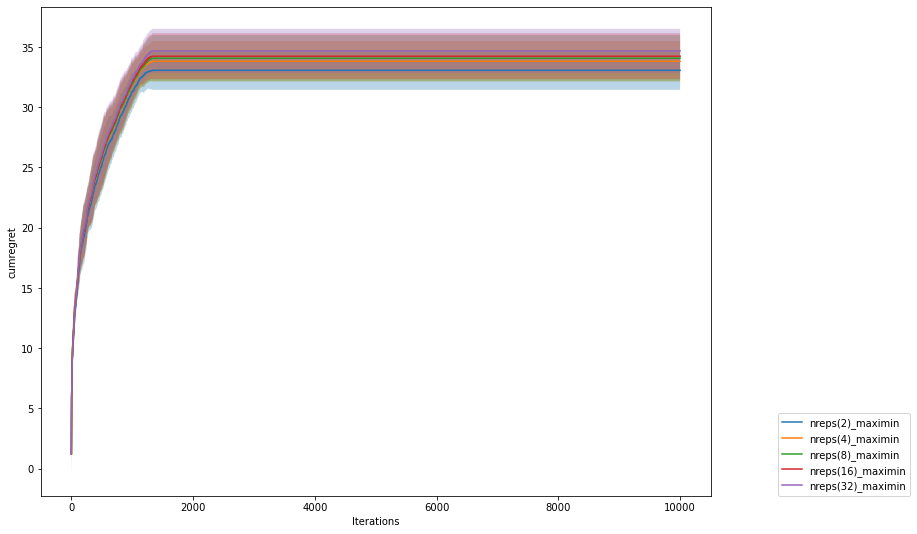

In [17]:
nu.compare('../logs', ['nreps(%d)_maximin' % i for i in values], 'cumregret', seeds)

## Varying Dimension

In [11]:
values = range(2, dim)
reps = []
for d in values:
    r = reduce_dim(r0, d, transform=True, normalize=True)
    r = derank_hls(r, 1)
    assert r==r0
    assert r.dim == d
    reps.append(r)

r = derank_hls(r0, 1, transform=True, normalize=True)
reps.append(r)

reps.append(r0)

for r in reps:
    print('%d: %d' % (r.dim, hls_rank(r)))

problem = FiniteMultiBandit(nc, na, reps)

2: 1
3: 1
4: 1
5: 1
5: 5


In [17]:
for i in range(len(reps)-1):
    problem.select_rep(i)
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, 
             logname='dims_oful(%d)' % reps[i].dim)

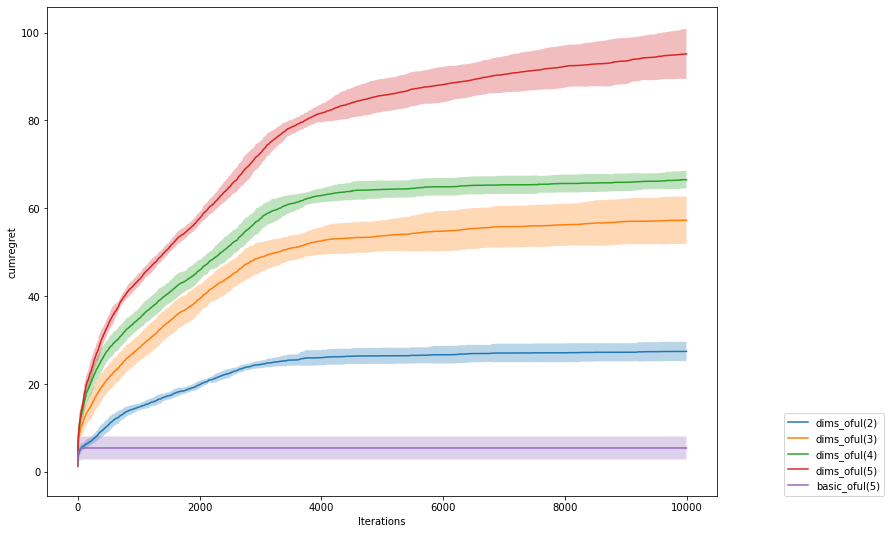

In [18]:
nu.compare('../logs', ['dims_oful(%d)' % d for d in range(2, dim+1)] + ['basic_oful(5)'], 'cumregret', seeds)

In [12]:
ranking = nu.tournament('../logs', ['dims_oful(%d)' % d for d in range(2, dim+1)], 'cumregret', seeds)
best = ranking[0][0]
ranking

[('dims_oful(2)', 27.399185977606255),
 ('dims_oful(3)', 57.26050704943795),
 ('dims_oful(4)', 66.49021779906909),
 ('dims_oful(5)', 95.14088972804694)]

In [20]:
problem.reset()
delta2 = delta / len(reps)
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='dims_lambdamin(u)')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='dims_lambdamin')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='dims_design')
    
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='dims_minbonus')
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='dims_maximin')

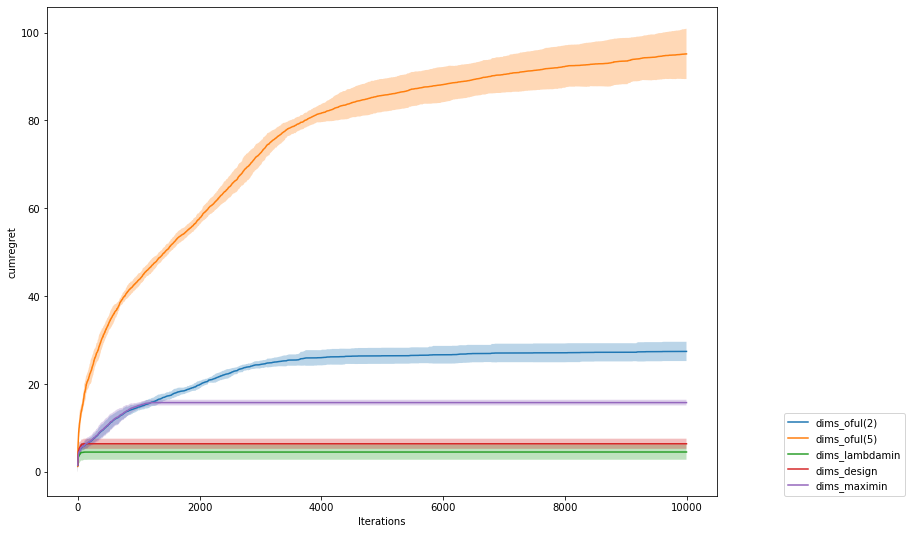

In [13]:
nu.compare('../logs', [best, 'dims_oful(5)', 'dims_lambdamin', 'dims_design', 'dims_maximin'], 'cumregret', seeds)

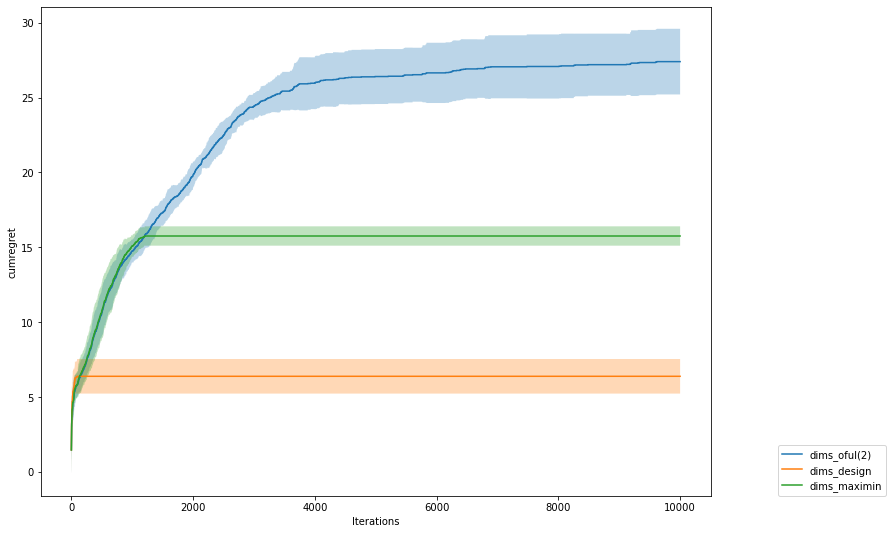

In [22]:
nu.compare('../logs', [best, 'dims_design', 'dims_maximin'], 'cumregret', seeds)

## Non-Uniform Contexts

Basic problem, but with non-uniform multinomial context distribution

In [14]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    
#Buldi multi-representation problem
cprobs = np.arange(1, nc+1)**2#np.random.uniform(size=nc)
cprobs = cprobs / np.sum(cprobs)
problem = FiniteMultiBandit(nc, na, reps, context_probs=cprobs)

<BarContainer object of 20 artists>

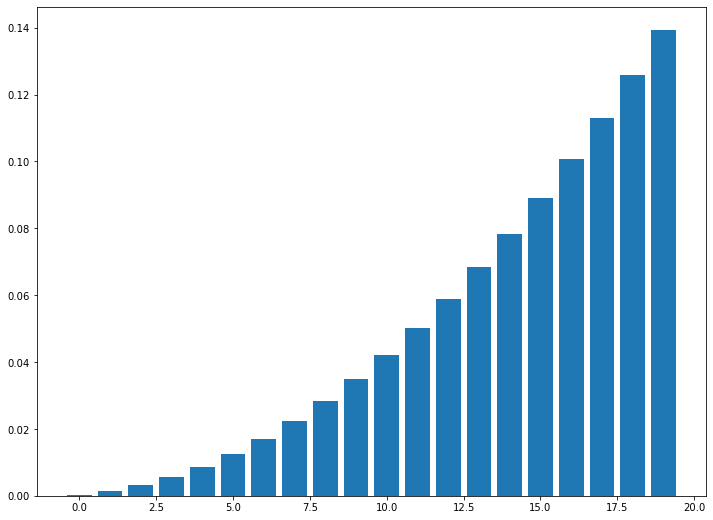

In [26]:
plt.bar(range(nc), cprobs)

In [27]:
hls_lambda(r0)

1.0207350383885851

In [28]:
hls_lambda(r0, cprobs)

0.6903684731402304

In [29]:
problem.select_rep(-1)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='context_oracle')

problem.select_rep(-2)
for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='context_dummy')

problem.reset()
delta2 = delta / len(reps)
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='context_lambdamin(u)')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='context_lambdamin')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='context_design')
    
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='context_minbonus')
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='context_maximin')

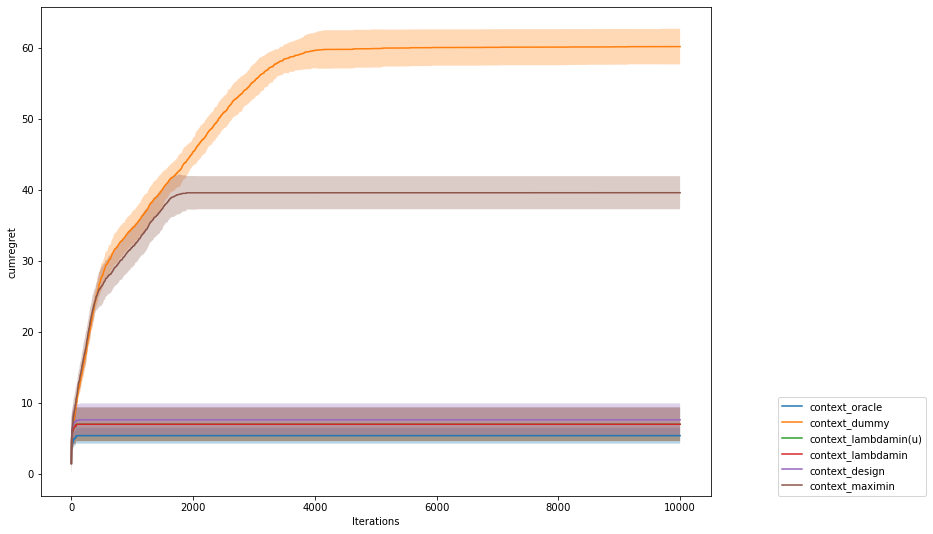

In [15]:
nu.compare('../logs', ['context_oracle', 'context_dummy', 'context_lambdamin(u)', 'context_lambdamin', 
                       'context_design', 'context_maximin'], 'cumregret', seeds)

## Composing Representations

In [5]:
reps = [fuse_columns(r0, [0,1,2,3]),
        fuse_columns(r0, [1,2,3,4]),
        fuse_columns(r0, [2,3,4,0]),
        fuse_columns(r0, [3,4,0,1]),
        fuse_columns(r0, [4,0,1,2])]

In [6]:
for r in reps:
    print(hls_rank(r))

2
2
2
2
2


In [7]:
problem = FiniteMultiBandit(nc, na, reps)
hls_rank_combined(problem)

5

In [8]:
for i in range(len(reps)):
    problem.select_rep(i)
    for seed in seeds:
            oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, 
                 logname='compose_oful(%i)' % i)

problem.reset()
delta2 = delta / len(reps)
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=True,
                seed=seed, verbose=False, logname='compose_lambdamin(u)')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='maxlambdamin', uniform=False,
                seed=seed, verbose=False, logname='compose_lambdamin')
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='design', uniform=False,
                seed=seed, verbose=False, logname='compose_design')
    
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta2, param_bound, 
                rule='minbonus', uniform=False,
                seed=seed, verbose=False, logname='compose_minbonus')
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta2, param_bound,
                seed=seed, verbose=False, logname='compose_maximin')

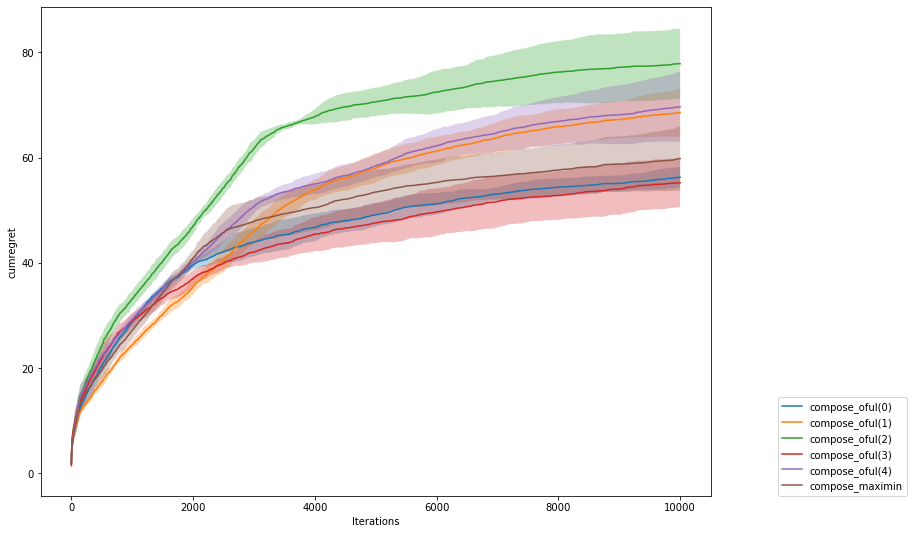

In [9]:
nu.compare('../logs', ['compose_oful(%i)' % i for i in range(len(reps))] + ['compose_maximin'], 'cumregret', seeds)